# Gaussian Mixture Models

A Gaussian Mixture Model (GMM) is a probabilistic model that represents data as a mixture of several Gaussian distributions. In machine learning, GMMs are primarily used for clustering and density estimation. Unlike methods like K-Means, which assign data points to single clusters, GMMs assign probabilities to each data point for belonging to each cluster. This "soft clustering" approach is useful when clusters are not well-separated or when uncertainty in cluster assignment is important. 

### Table of Contents
1. [GMM Initialization Methods](#GMM-Initialization-Methods)
2. [GMM covariances](#GMM-covariances)

## GMM Initialization Methods

Examples of the different methods of initialization in Gaussian Mixture Models

See Gaussian mixture models for more information on the estimator.

Here we generate some sample data with four easy to identify clusters. The purpose of this example is to show the four different methods for the initialization parameter init_param.

The four initializations are kmeans (default), random, random_from_data and k-means++.

Orange diamonds represent the initialization centers for the gmm generated by the init_param. The rest of the data is represented as crosses and the colouring represents the eventual associated classification after the GMM has finished.

The numbers in the top right of each subplot represent the number of iterations taken for the GaussianMixture to converge and the relative time taken for the initialization part of the algorithm to run. The shorter initialization times tend to have a greater number of iterations to converge.

The initialization time is the ratio of the time taken for that method versus the time taken for the default kmeans method. As you can see all three alternative methods take less time to initialize when compared to kmeans.

In this example, when initialized with random_from_data or random the model takes more iterations to converge. Here k-means++ does a good job of both low time to initialize and low number of GaussianMixture iterations to converge.

Automatically created module for IPython interactive environment


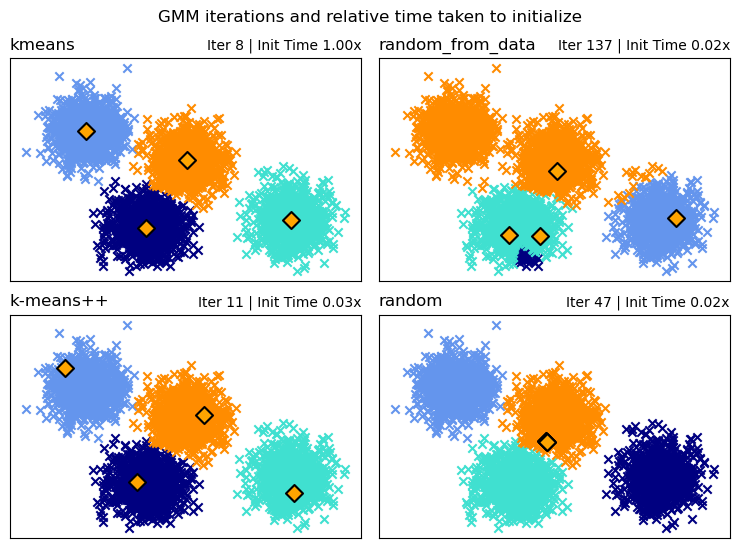

In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms

print(__doc__)

# Generate some data

X, y_true = make_blobs(n_samples=4000, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]

n_samples = 4000
n_components = 4
x_squared_norms = row_norms(X, squared=True)


def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=4, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_


methods = ["kmeans", "random_from_data", "k-means++", "random"]
colors = ["navy", "turquoise", "cornflowerblue", "darkorange"]
times_init = {}
relative_times = {}

plt.figure(figsize=(4 * len(methods) // 2, 6))
plt.subplots_adjust(
    bottom=0.1, top=0.9, hspace=0.15, wspace=0.05, left=0.05, right=0.95
)

for n, method in enumerate(methods):
    r = np.random.RandomState(seed=1234)
    plt.subplot(2, len(methods) // 2, n + 1)

    start = timer()
    ini = get_initial_means(X, method, r)
    end = timer()
    init_time = end - start

    gmm = GaussianMixture(
        n_components=4, means_init=ini, tol=1e-9, max_iter=2000, random_state=r
    ).fit(X)

    times_init[method] = init_time
    for i, color in enumerate(colors):
        data = X[gmm.predict(X) == i]
        plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

    plt.scatter(
        ini[:, 0], ini[:, 1], s=75, marker="D", c="orange", lw=1.5, edgecolors="black"
    )
    relative_times[method] = times_init[method] / times_init[methods[0]]

    plt.xticks(())
    plt.yticks(())
    plt.title(method, loc="left", fontsize=12)
    plt.title(
        "Iter %i | Init Time %.2fx" % (gmm.n_iter_, relative_times[method]),
        loc="right",
        fontsize=10,
    )
plt.suptitle("GMM iterations and relative time taken to initialize")
plt.show()

## GMM covariances

Demonstration of several covariances types for Gaussian mixture models.

See Gaussian mixture models for more information on the estimator.

Although GMM are often used for clustering, we can compare the obtained clusters with the actual classes from the dataset. We initialize the means of the Gaussians with the means of the classes from the training set to make this comparison valid.

We plot predicted labels on both training and held out test data using a variety of GMM covariance types on the iris dataset. We compare GMMs with spherical, diagonal, full, and tied covariance matrices in increasing order of performance. Although one would expect full covariance to perform best in general, it is prone to overfitting on small datasets and does not generalize well to held out test data.

On the plots, train data is shown as dots, while test data is shown as crosses. The iris dataset is four-dimensional. Only the first two dimensions are shown here, and thus some points are separated in other dimensions.

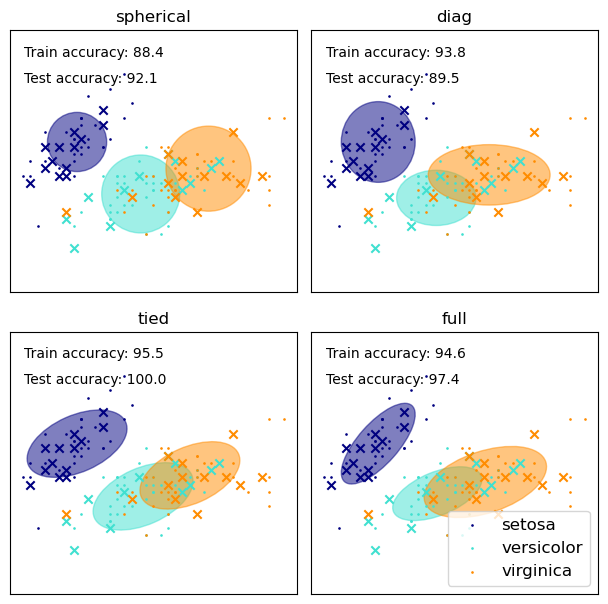

In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()